In [1]:
# Impoprt libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
# Import dataset 
df = pd.read_csv(r"C:\Users\cease\Documents\Datasets\End to End Projects\House Price Prediction.csv")

df.head()

,Median_House_Value,Median_Income,Median_Age,Tot_Rooms,Tot_Bedrooms,Population,Households,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
0,452600.0,8.3252,41,880,129,322,126,37.88,-122.23,9263.040773,556529.158342,735501.806984,67432.517001,21250.213767
1,358500.0,8.3014,21,7099,1106,2401,1138,37.86,-122.22,10225.733072,554279.850069,733236.884360,65049.908574,20880.600400
2,352100.0,7.2574,52,1467,190,496,177,37.85,-122.24,8259.085109,554610.717069,733525.682937,64867.289833,18811.487450
3,341300.0,5.6431,52,1274,235,558,219,37.85,-122.25,7768.086571,555194.266086,734095.290744,65287.138412,18031.047568
4,342200.0,3.8462,52,1627,280,565,259,37.85,-122.25,7768.086571,555194.266086,734095.290744,65287.138412,18031.047568


In [3]:
# Data Summary 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Median_House_Value        20640 non-null  float64
 1   Median_Income             20640 non-null  float64
 2   Median_Age                20640 non-null  int64  
 3   Tot_Rooms                 20640 non-null  int64  
 4   Tot_Bedrooms              20640 non-null  int64  
 5   Population                20640 non-null  int64  
 6   Households                20640 non-null  int64  
 7   Latitude                  20640 non-null  float64
 8   Longitude                 20640 non-null  float64
 9   Distance_to_coast         20640 non-null  float64
 10  Distance_to_LA            20640 non-null  float64
 11  Distance_to_SanDiego      20640 non-null  float64
 12  Distance_to_SanJose       20640 non-null  float64
 13  Distance_to_SanFrancisco  20640 non-null  float64
dtypes: flo

In [4]:
# Checking for null values 
df.isnull().sum()

Median_House_Value          0
Median_Income               0
Median_Age                  0
Tot_Rooms                   0
Tot_Bedrooms                0
Population                  0
Households                  0
Latitude                    0
Longitude                   0
Distance_to_coast           0
Distance_to_LA              0
Distance_to_SanDiego        0
Distance_to_SanJose         0
Distance_to_SanFrancisco    0
dtype: int64

In [5]:
# Rename columns 
df = df.rename(columns={'Tot_Rooms':'Total Rooms', 'Tot_Bedrooms':'Total_Bedrooms' })

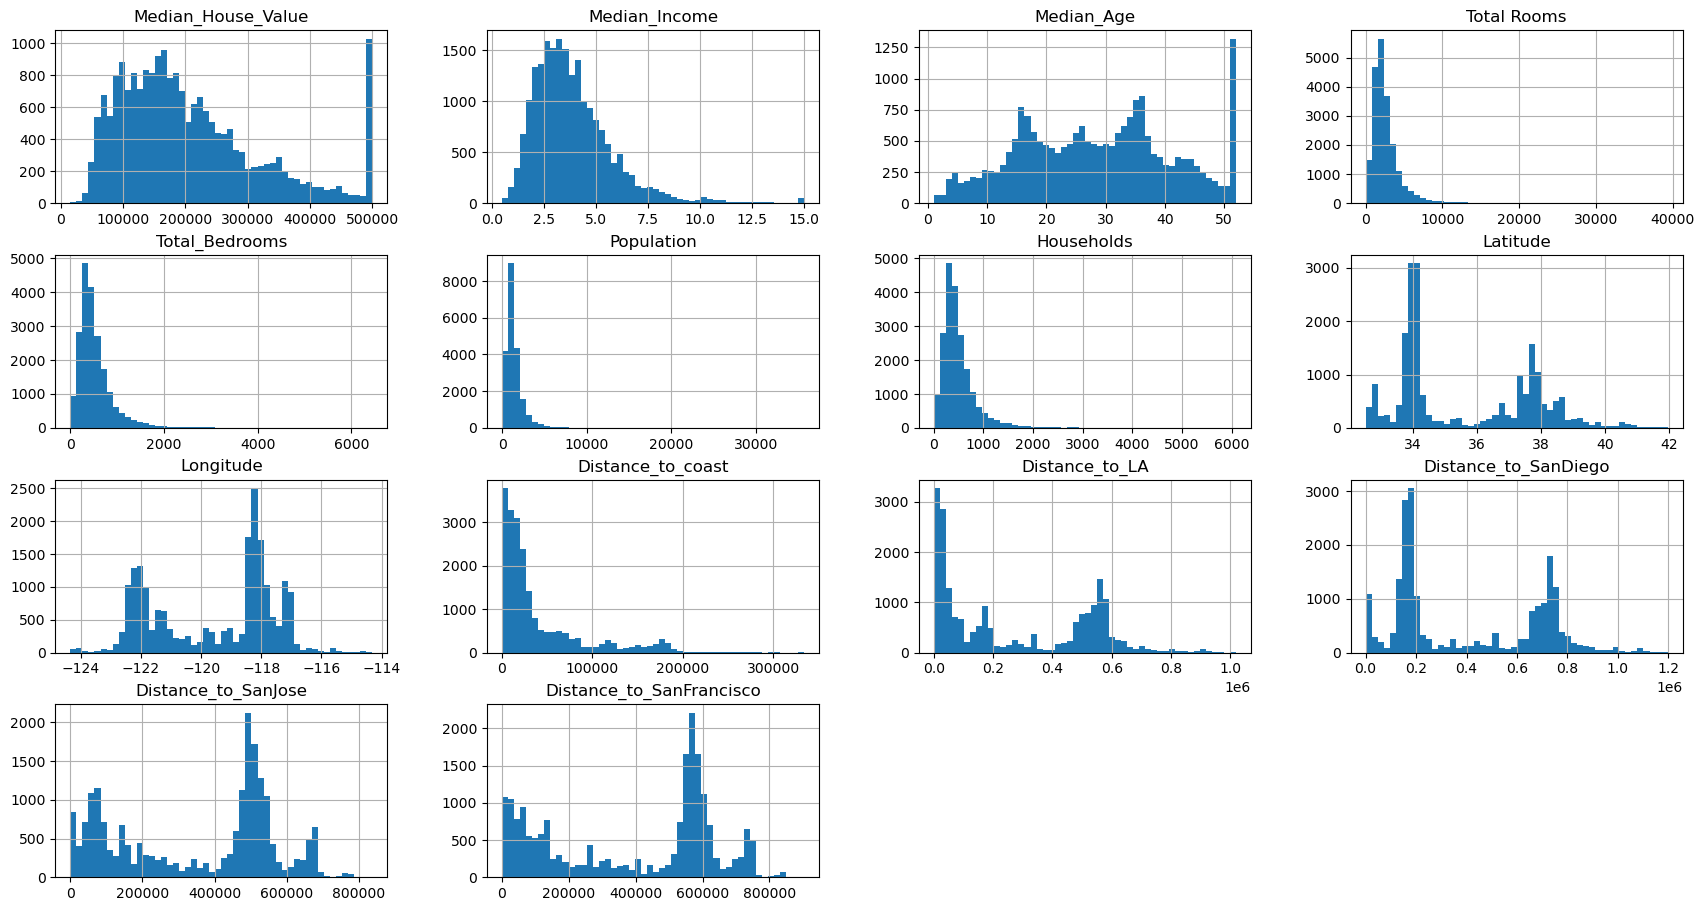

In [6]:
# Data distribution for numeric columns 
df.hist(bins=50, figsize=(21,11))

plt.show()

- The housing median age and the median house value were capped. The latter may be a serious problem since it is your target attribute (The Machine Learning algorithms may learn that prices never go beyond that limit.) We will remove those restrictions
- These attributes have very different scales.
- Many histograms are tail heavy: they extend much farther to the right of the median than to the left.  

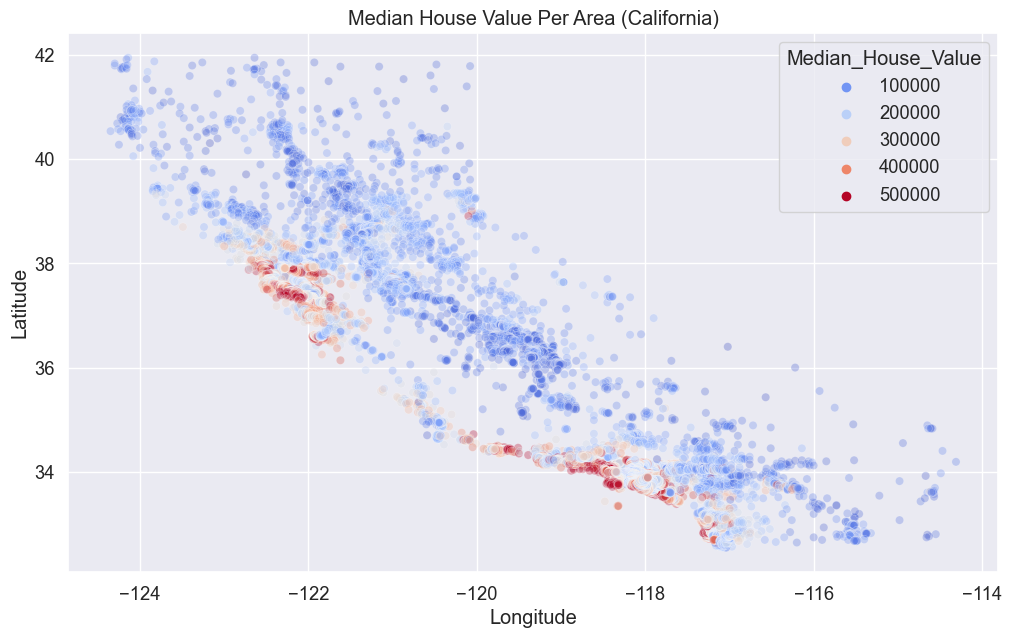

In [7]:
## Visualizing geographic distribution of houses  
sns.set(rc={'figure.figsize': [12, 7]}, font_scale=1.2)
ax = sns.scatterplot(data=df, x='Longitude', y='Latitude', hue='Median_House_Value', palette='coolwarm', alpha=0.3);
ax.set_title("Median House Value Per Area (California)");

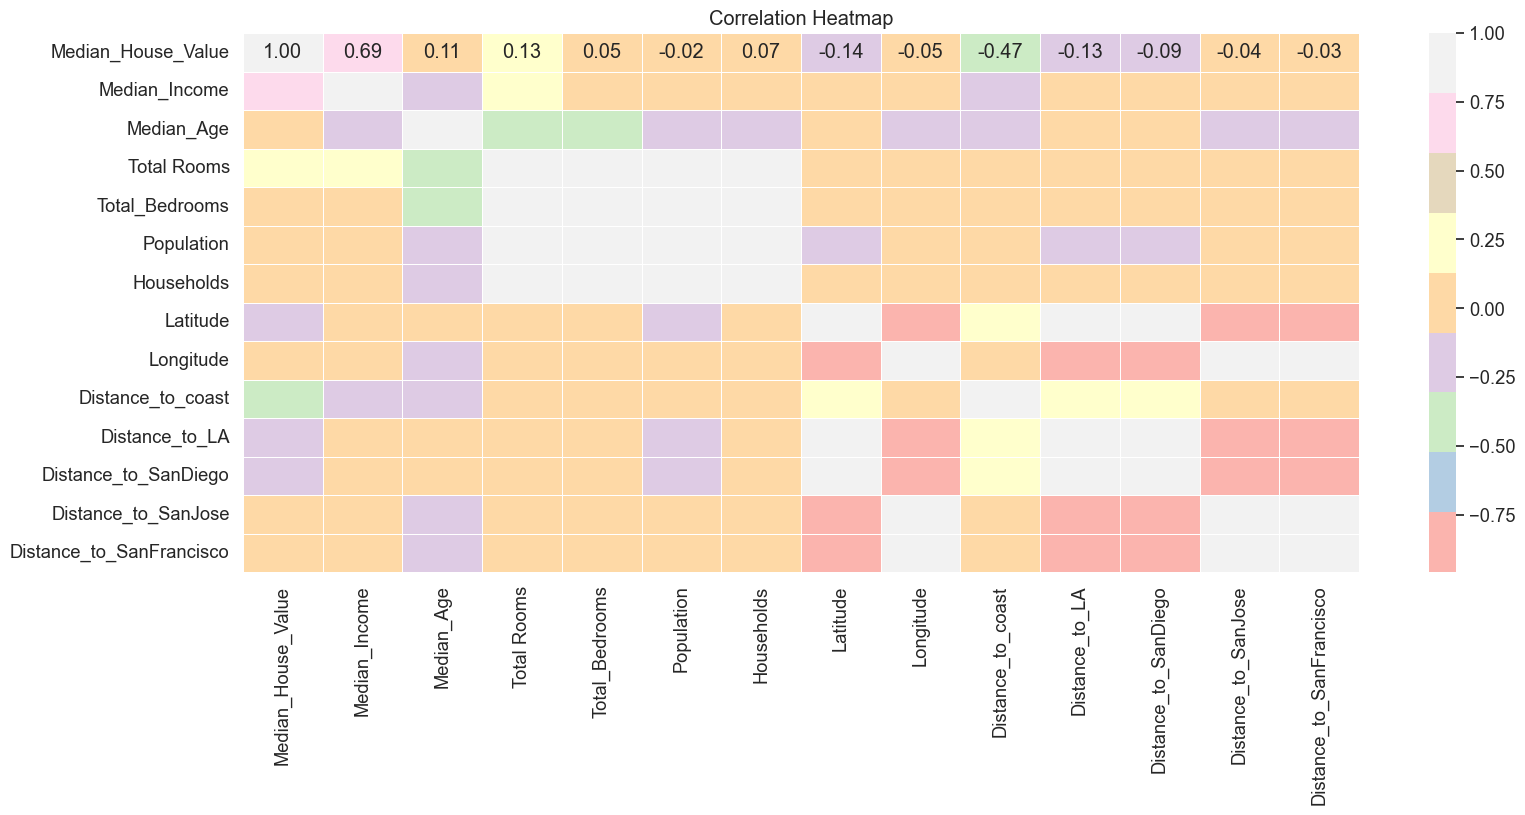

In [8]:
# Correlation analysis of the attributes  
correlation_matrix = df.corr()
# Create a heatmap
plt.figure(figsize=(18, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='Pastel1', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [9]:
# Removing capping 
def remove_outliers_iqr(data, cap_value=None):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    
    # Calculate IQR (Interquartile Range)
    IQR = Q3 - Q1
    
    # Define lower bound for outlier removal
    lower_bound = Q1 - 1.5 * IQR
    
    # Define upper bound for outlier removal
    if cap_value is not None:
        upper_bound = min(cap_value, Q3 + 1.5 * IQR)
    else:
        upper_bound = Q3 + 1.5 * IQR
   
    # Remove outliers
    outliers_removed = data[(data >= lower_bound) & (data <= upper_bound)]
    
    return outliers_removed

# Remove outliers from 'Median_House_Value' column
df['Median_House_Value'] = remove_outliers_iqr(df['Median_House_Value'])

# Remove outliers from 'Median_Age' column considering the cap at 50
df['Median_Age'] = remove_outliers_iqr(df['Median_Age'], cap_value=50)

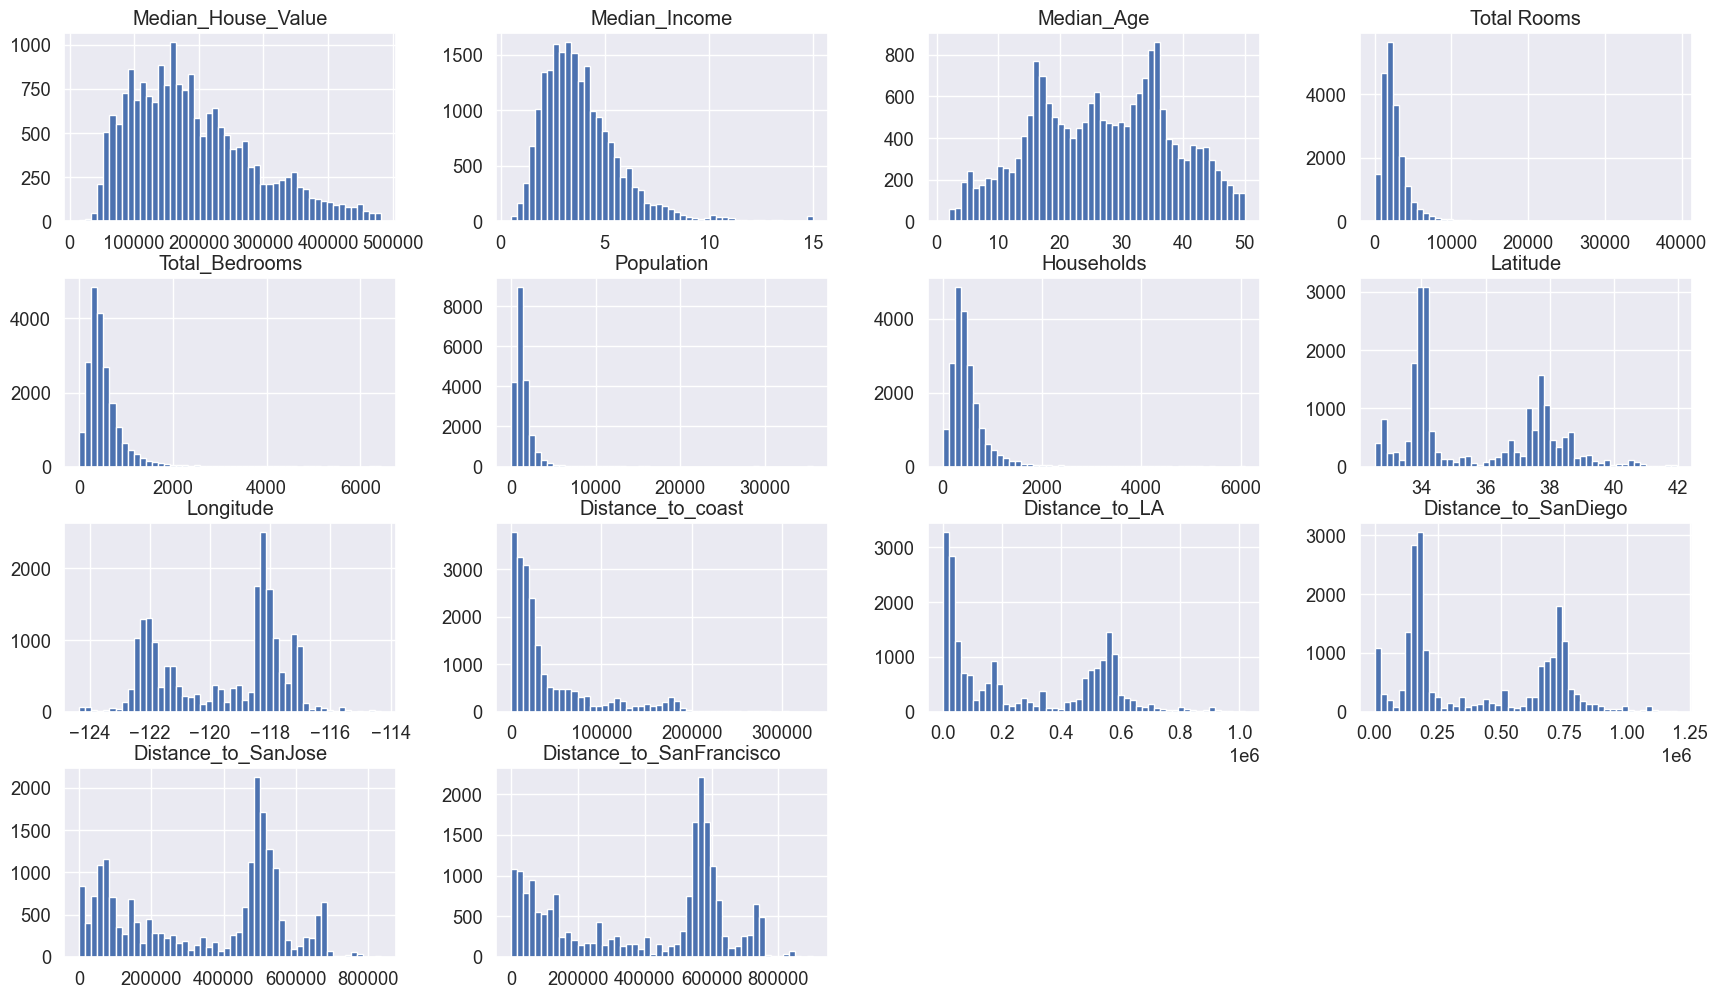

In [10]:
# Data distribution for numericc columns after removing the cap 
df.hist(bins=50, figsize=(21, 12))

plt.show()

### Build the model 

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score

# Evaluation 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [12]:
# Define the featuires and target variable 

# drop null values
df = df.dropna()

# Features 
X = df.drop(columns={'Median_House_Value'})

# Target variable 
y = df['Median_House_Value']

In [13]:
# Training set and testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [14]:
# Initialize the standard scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data
X_test_scaled = scaler.transform(X_test)

In [15]:

def model(X_train_scaled, y_train, X_test_scaled, y_test):
    # Initialize the XGBRegressor model
    xgb_model = XGBRegressor()

    # Fit the model on the entire training data
    xgb_model.fit(X_train_scaled, y_train)

    # Make predictions on the testing data
    y_pred = xgb_model.predict(X_test_scaled)

    # Evaluate the model on the testing data
    mae_test = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)

    # Return the evaluation metrics
    return mae_test, r2_test

# Example usage:
# Assuming you have defined X_train_scaled, y_train, X_test_scaled, and y_test
mae_test, r2_test = model(X_train_scaled, y_train, X_test_scaled, y_test)

print("MAE:", mae_test)
print("R2:", r2_test)


MAE: 27284.25446882341
R2: 0.8185935647910383


## Feature importance 

In [16]:
# Feature importance 
# Fit the Random Forest model to training data
xgb_model = XGBRegressor()
xgb_model.fit(X_train_scaled, y_train)

# Get feature importances
feature_importance = xgb_model.feature_importances_

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
feature_importance_df

,Feature,Importance
0,Median_Income,0.276612
8,Distance_to_coast,0.216659
6,Latitude,0.084169
10,Distance_to_SanDiego,0.069852
12,Distance_to_SanFrancisco,0.065701
11,Distance_to_SanJose,0.062667
7,Longitude,0.050531
9,Distance_to_LA,0.048891
4,Population,0.031883
2,Total Rooms,0.025046


## Retrain the model without leat important features

In [17]:
# Features 
Xn = X.drop(columns={'Total_Bedrooms', 'Median_Age', 'Households'})

# Target variable 
y = df['Median_House_Value']

In [18]:
Xn.head()

,Median_Income,Total Rooms,Population,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
0,8.3252,880,322,37.88,-122.23,9263.040773,556529.158342,735501.806984,67432.517001,21250.213767
1,8.3014,7099,2401,37.86,-122.22,10225.733072,554279.850069,733236.884360,65049.908574,20880.600400
8,2.0804,2555,1206,37.84,-122.26,6363.948013,554949.749519,733820.824419,64751.463863,16744.406584
15,2.1250,1120,697,37.85,-122.26,7349.620842,555778.657669,734665.575039,65716.117724,17260.032074
18,1.9911,2239,990,37.84,-122.26,6363.948013,554949.749519,733820.824419,64751.463863,16744.406584


In [19]:
y.head()

0     452600.0
1     358500.0
8     226700.0
15    140000.0
18    158700.0
Name: Median_House_Value, dtype: float64

In [20]:
# Training set and testing split
Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size=0.30, random_state=42)

# Fit and transform the training data
Xn_train_scaled = scaler.fit_transform(Xn_train)

# Transform the testing data
Xn_test_scaled = scaler.transform(Xn_test)

In [21]:
# def model(Xn_train_scaled, y_train, Xn_test_scaled, y_test):
#     # Initialize the XGBRegressor model
#     xgb_model = XGBRegressor()

#     # Fit the model on the entire training data
#     xgb_model.fit(Xn_train_scaled, y_train)

#     # Make predictions on the testing data
#     y_pred = xgb_model.predict(Xn_test_scaled)

#     # Evaluate the model on the testing data
#     mae_test = mean_absolute_error(y_test, y_pred)
#     r2_test = r2_score(y_test, y_pred)

#     # Return the evaluation metrics
#     return mae_test, r2_test

# # Example usage:
# # Assuming you have defined X_train_scaled, y_train, X_test_scaled, and y_test
# mae_test, r2_test = model(Xn_train_scaled, y_train, Xn_test_scaled, y_test)

# print("MAE:", mae_test)
# print("R2:", r2_test)

In [22]:

# Initialize the XGBRegressor model
xgb_model = XGBRegressor()

# Fit the model on the entire training data
xgb_model.fit(Xn_train_scaled, y_train)

# Make predictions on the testing data
y_pred = xgb_model.predict(Xn_test_scaled)

# Evaluate the model on the testing data
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print("MAE:", mae_test)
print("R2:", r2_test)

MAE: 27327.229469952792
R2: 0.8151475030339999


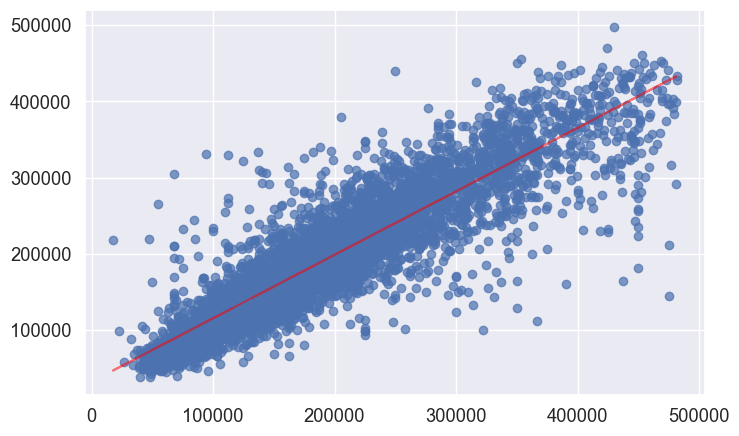

In [23]:
# Plot a scatter plot for prediction 
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.7, label='Actual vs. Predicted')

# Add trendline
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='red', label='Trendline', alpha=0.5)

# Show plot
plt.show()


In [24]:
# Residuals (error wrt y_test, y_pred) 
residuals = y_test -  y_pred
residuals

7326     -24272.343750
14429    -37811.187500
4951     -15967.484375
11633     33156.390625
9076      23894.765625
             ...      
11746   -114374.375000
18978    -10513.406250
8679      34034.250000
275      -92718.062500
2790      29787.289062
Name: Median_House_Value, Length: 5534, dtype: float64

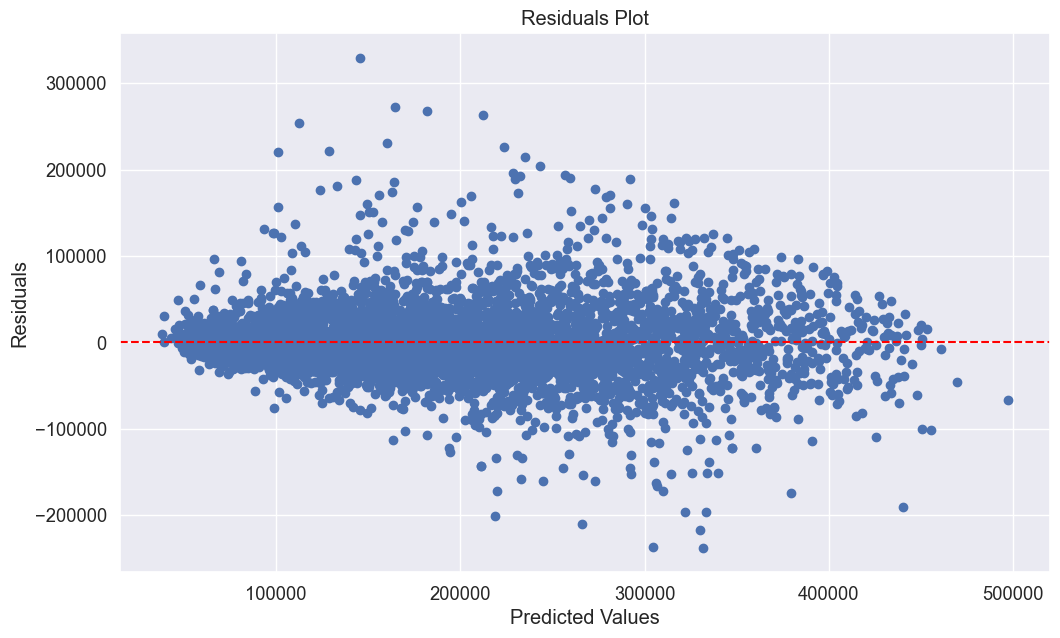

In [25]:
# Scatter plot residuals and predictions

# Calculate residuals
residuals = y_test - y_pred

# Create a scatter plot of predicted values vs. residuals
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

C:\Users\cease\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


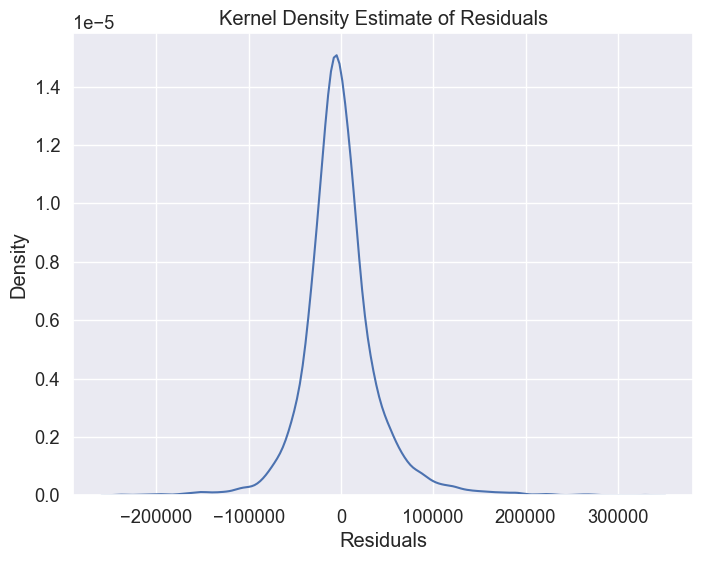

In [26]:
# Plot the residuals
plt.figure(figsize=(8, 6))
sns.kdeplot(residuals)

# Labels
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.title("Kernel Density Estimate of Residuals")

# Show the plot
plt.show()

## Prediction using the model 

In [27]:
Xn.head()

,Median_Income,Total Rooms,Population,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
0,8.3252,880,322,37.88,-122.23,9263.040773,556529.158342,735501.806984,67432.517001,21250.213767
1,8.3014,7099,2401,37.86,-122.22,10225.733072,554279.850069,733236.884360,65049.908574,20880.600400
8,2.0804,2555,1206,37.84,-122.26,6363.948013,554949.749519,733820.824419,64751.463863,16744.406584
15,2.1250,1120,697,37.85,-122.26,7349.620842,555778.657669,734665.575039,65716.117724,17260.032074
18,1.9911,2239,990,37.84,-122.26,6363.948013,554949.749519,733820.824419,64751.463863,16744.406584


In [28]:
Xn_train.head()

,Median_Income,Total Rooms,Population,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
1517,3.7433,7201,3264,37.93,-122.07,13380.120512,551632.213014,730841.340570,67919.617695,36156.128222
20216,4.8824,1189,445,34.30,-119.25,5004.937845,96586.330148,261794.009667,413135.928902,480594.738669
2385,3.5074,1486,977,36.59,-119.40,187006.663063,301048.987607,476956.303686,236492.836648,299058.749742
1151,1.5771,1733,1861,39.53,-121.56,160895.968878,676774.500450,854241.040331,245736.988179,209404.808100
3664,3.6000,1444,1177,34.23,-118.37,26760.913377,22931.645413,202293.505721,469214.844141,537248.582704


In [29]:
# Assuming Xn is the new data
# Preprocess the new data (scaling, encoding categorical variables, etc.)
Xn_scaled = scaler.transform(Xn)  # Assuming 'scaler' is the scaler used for scaling the training data

# Take the first row of the preprocessed new data
first_row_Xn_scaled = Xn_scaled[0:10]  # Assuming Xn_scaled is a NumPy array

# Make predictions on the first row of the new data
prediction_first_row = xgb_model.predict(first_row_Xn_scaled)

print("Prediction for the first row:", prediction_first_row)


Prediction for the first row: [416213.7  376928.2  172781.8  158303.66 163379.94 158609.06 159383.3
 123541.83 141197.47 122028.42]


In [30]:
y.head(10)

0     452600.0
1     358500.0
8     226700.0
15    140000.0
18    158700.0
20    147500.0
21    159800.0
25    107500.0
26     93800.0
28    108900.0
Name: Median_House_Value, dtype: float64

In [31]:
y_train.head()

1517     252100.0
20216    396400.0
2385      93800.0
1151      65200.0
3664     164600.0
Name: Median_House_Value, dtype: float64

## Model Picling 

In [32]:
import pickle
import joblib

# Save the scaler to a pickled file with the name 'scaler.pkl'
scaler_filename = 'scaler.pkl'
joblib.dump(scaler, scaler_filename)

# Save the regression model to a pickled file
model_filename = 'xgb_model.joblib'
joblib.dump(xgb_model, model_filename)

print(f"Scaler saved to {scaler_filename}")
print(f"Regression model saved to {model_filename}")


Scaler saved to scaler.pkl
Regression model saved to xgb_model.joblib


In [33]:
from joblib import dump

# Save the XGBRegressor model using joblib
dump(xgb_model, "xgb_model.joblib")

print("XGBRegressor model saved successfully using joblib.")


XGBRegressor model saved successfully using joblib.


### Make predictions using Pickled file

In [34]:
from joblib import load

# Load the saved XGBRegressor model
loaded_model = load("xgb_model.joblib")

# Assuming Xn_scaled is the new data preprocessed in the same way as the training data
# Make predictions using the loaded model
predictions = loaded_model.predict(Xn_scaled)

print("Predictions:", predictions)


Predictions: [416213.7  376928.2  172781.8  ...  85613.91  65578.84  88036.37]
